<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit7/Unit7NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

# Unit 7: Fitting Curves

This unit will give you an intuition to a very powerful mathematical concept that underpins all the most powerful predictions people have come up with--at least, as of this writing.

This mathematical concept is called a Gaussian Process (GP). To understand what it is, we'll need to finish with the basics of generlized linear models--specifically, to see some examples of polynomial regression, and b splines. Using those examples, we can get a surface level understanding of what a GP is.

We'll then implement an approximation of a GP called a Hilbert Space GP, or HSGP.

These concepts involve a lot of mathematics. I will try to keep our disscussions high level, but even so this is challenging material. Be gentle with yourself.

Throuhgout this unit, keep this question in mind: How can we find *all* the patterns in our data, without overfitting?

### Comments on Under/Overfitting

Until now, I've instructed y'all to have a bias towards simpler models, even if they capture less patterns in the data. We're going to put that aside for now, for two reasons:
- I want to show the most powerful methods, so you can use them if they do turn out to be best
- There are ways to help these more powerful methods avoid overfitting. Well, except for polynomial regression.

GLMs still have their place, especially in situations where we mostly understand what's going on. But for data with complicated and obscure relationships, the methods in this and the next Unit are almost always better for prediction, and not too bad when it comes to interpretation either.

### Polynomial Regression

To start our curve fitting journey, let's talk about the function type that I've avoid thus far: polynomials.

Review: a polynomial is when we multipy our input value, or predictor, by itself a number of times. We usually represent them mathematically as in the formula below:

$μ = β_{0} + β_{1}x +β_{2}x^{2} + β_{3}x^{3} + β_{4}x^{4} + . . . + β_{d}x^{d}$

where $d$ is the degree of the polynomial we want.

If we wanted to model hour versus rented from the bikes data with a fourth degree polynomial, we can write

```"rented ~ hour + I(hour ** 2) + I(hour ** 3) + I(hour ** 4)"```

or

``` "temperature ~ poly(hour,4)"```

We'll use the second method, both because it's easier to right, and because it makes our polynomial terms be orthogonal to each other. The important things about orthongonality are: it makes it easier for MCMC to run,  and easier to interpret our intercepts, because the orthongality of the terms means they are more independent.

That's enough sentences though; let's look at code and graphs.

And let's start by seeing that a "one degree polynomial" is what we;ve been doing with linear regression until now..

In [2]:
bikes = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv')

In [3]:
#one degree model for bikes; this is the "best" model, up till now.
model_poly_1 = bmb.Model("rented ~ hour", bikes, family="negativebinomial")
idata_poly_1 = model_poly_1.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, hour]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: hour


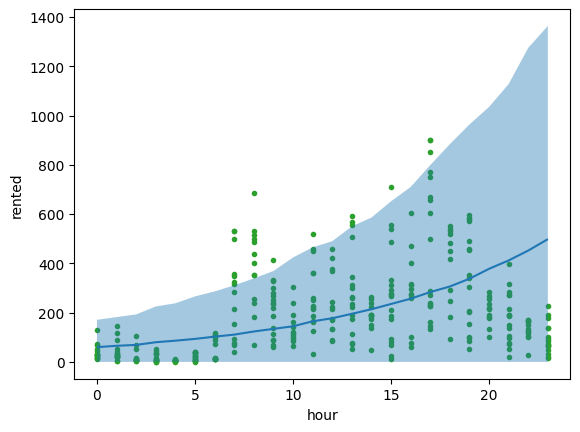

In [4]:
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "hour", pps=True)
plt.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)

**Task1**:

What pattern in the data is the one degreee negative binomial model NOT capturing? In other words, what part of the graph looks like its "missing" the data?

The part of the dataset between 5 and 10 is left out. The data is represented by a generally upwards-curving graph despite the fact that there seem to be multiple peaks, while the end is a low-point. This is not at all shown by the current model.

Let's run a polynomial model, to see if we can imporve our fit.

In [5]:
#degree 4 polynomial model
model_poly_4 = bmb.Model("rented ~ poly(hour, degree=4)", bikes, family="negativebinomial")
idata_poly_4 = model_poly_4.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, poly(hour, degree=4)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: hour


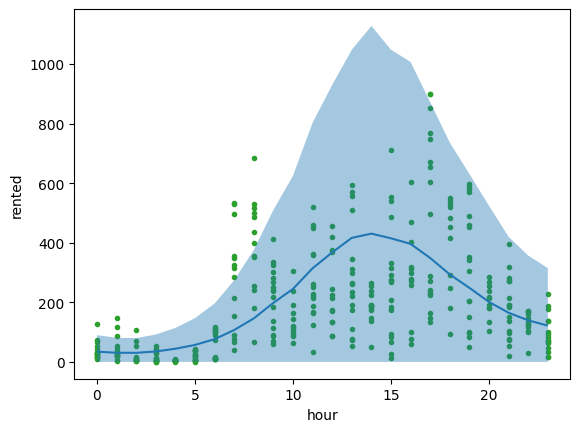

In [6]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "hour", pps=True)
#raw data
plt.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)

**Task2**:

Does the polynomial degree 4 model improve our fit from the one degree model?

It did. Now the model curves downward in the end as it should. However, it now overestimates rented bikes from 10-15 and still underestimates rented bikes from 5 to 10.

Let's see what happens when we increase the degree even more.

In [7]:
#degree 7 polynomial model
model_poly_7 = bmb.Model("rented ~ poly(hour, degree=7)", bikes, family="negativebinomial")
idata_poly_7 = model_poly_7.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, poly(hour, degree=7)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: hour


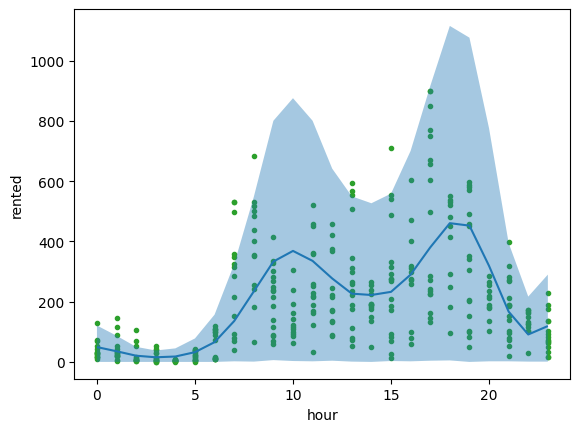

In [8]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_7, idata_poly_7, "hour", pps=True)
#raw data
plt.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)

**Task3**:

Does increasing the degree to 7 improve the fit for this model?

Yes. Now the model captures the data quite well and all previously mentioned issues were fixed.

Are polynomials always this effective?

No. They work better when the data has a more complicated relationship, and they have the drawback of overfitting to the given data, and predicting poorly, if we get to zeolous with jacking up our degree.

Let's see an example where a simpler model probably would've been better.

In [9]:
#degree 7 polynomial model for temp
model_poly_7_t = bmb.Model("rented ~ poly(temperature, degree=7)", bikes, family="negativebinomial")
idata_poly_7_t = model_poly_7_t.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, poly(temperature, degree=7)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temperature


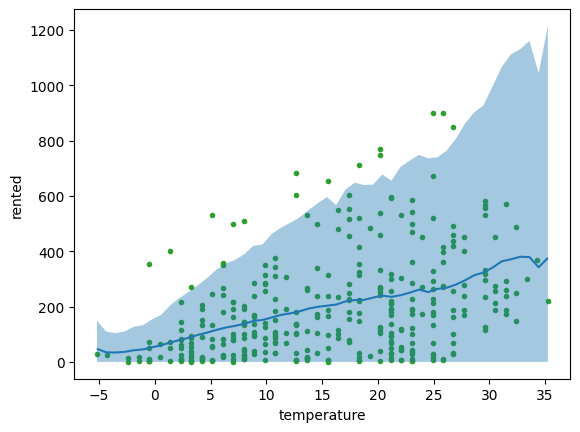

In [10]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_7_t, idata_poly_7_t, "temperature", pps=True)
#raw data
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

**Task4**:

Do you think a degree 7 polynomial is a good fit for modeling temperature versus rented?

No. The model is wiggly, trying to show trends that don't really matter.

Would an even higher degree polynomial solve the problem, or should we give up and use a lower degree polynomial?

No, a higher degree polynomial would worsten the problem because the higher the degree, the better the model is at approximating the data directly.

### B Splines

B splines a a great way to get the flexibility of polynomial regression, with less overfitting.

We will spend some time going over the concept of a B Spline, because it will form our intuition for Guassian Processes.

A good way to think of our next technique is as Weighted Piecewise Polynomial Regression.

Let's dissect that, starting with the "piecwise" part.

Piecewise means we slice up our x axis into, well, pieces. Those pieces are represented by the vertical dotted lines below.

Within each piece, we then fit a polynomial regression to the data in the given piece. In this case, the faint dashed curve in teh background is the data.
The left box is a spline with an intercept only model. The middle box is a one degree polynomial model, and the third box is a two degree polynomial model, or a quadratic.

Some vocabulary: "knots" are our name for the median x value of the pieces.

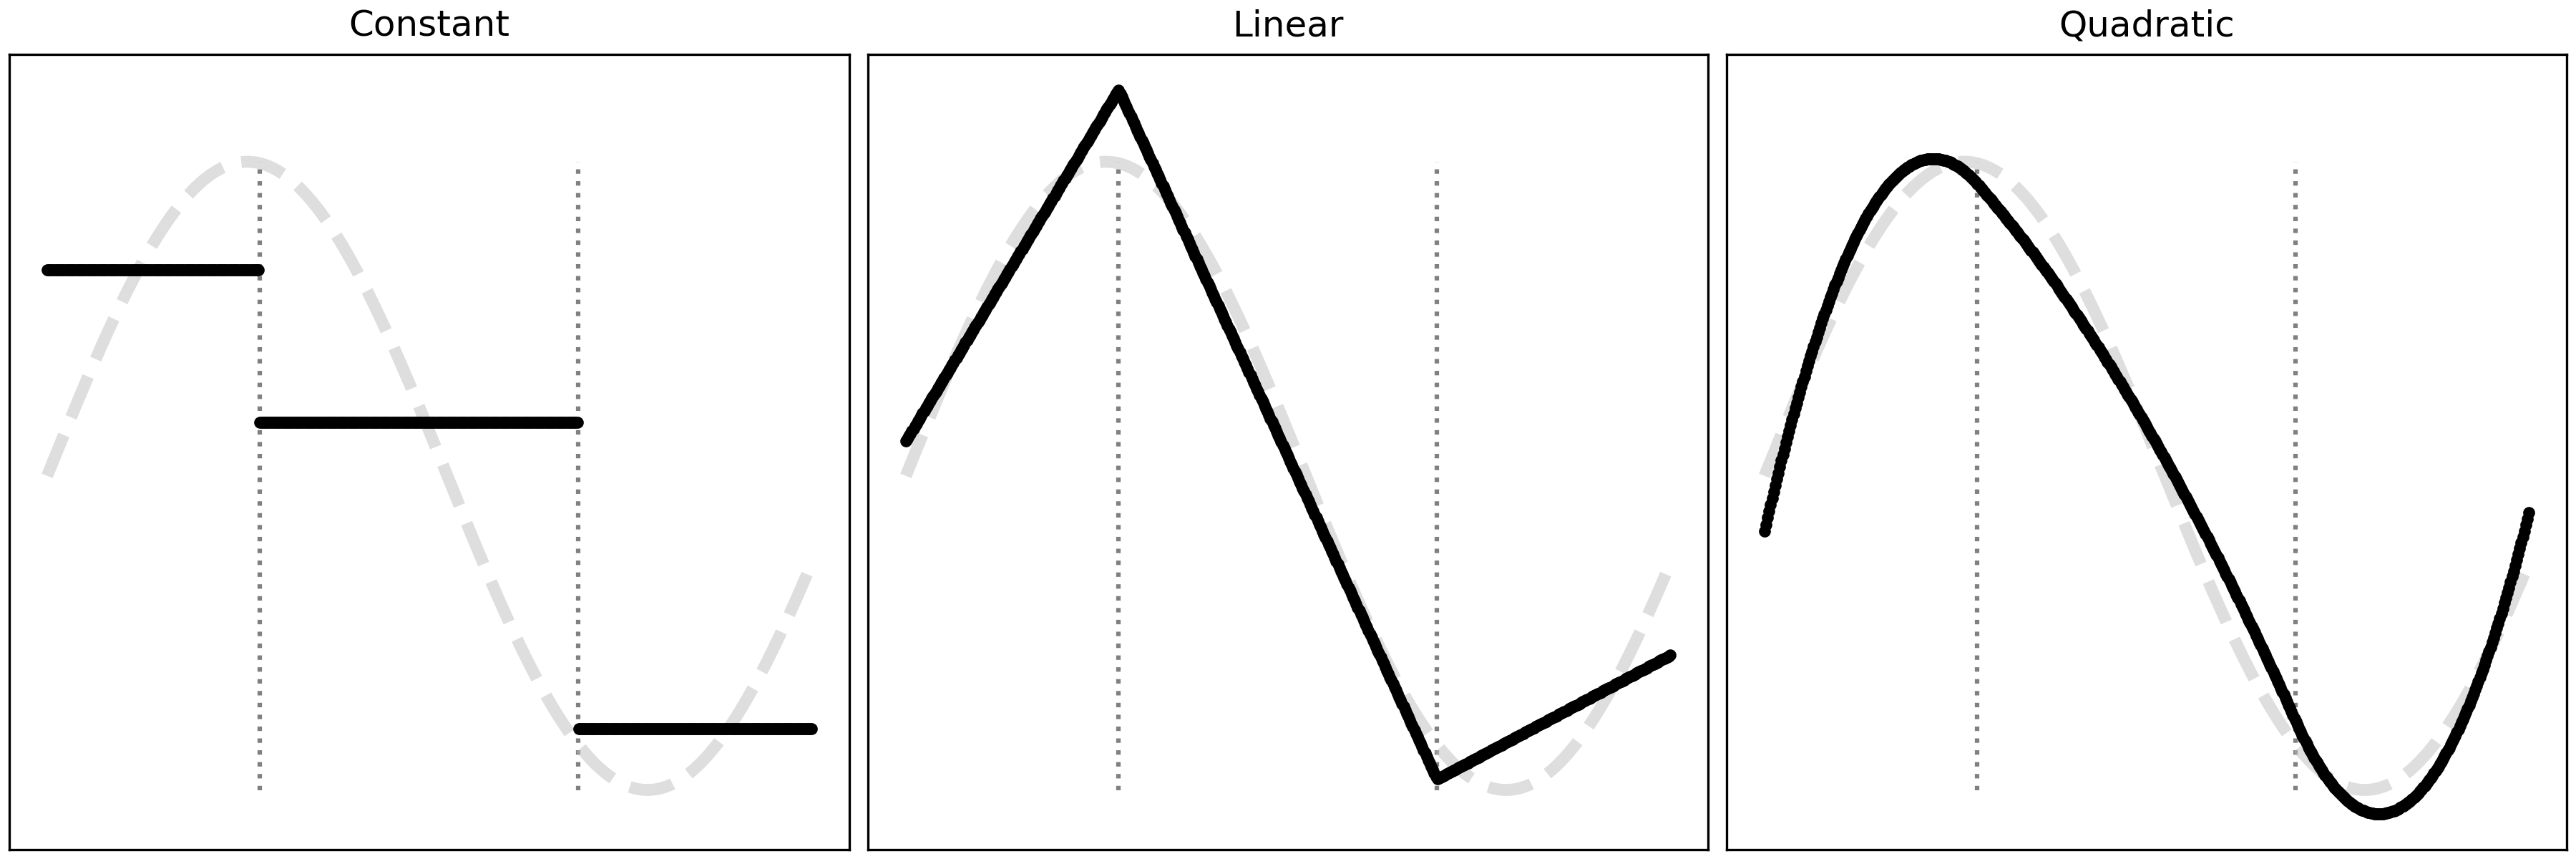

Now that we know what the "piecewise polynomial" part means, let's dive into the "weighted" part.

Unlike the above picture, our data is rarely lined up neatly like the faded dashed line above. There are often clumps, or concentrations of data. Like in the temperature vs. rented graph, where there are less data for high temperatures, but more for lower temperatures.

We'd want to weight the temps below 25 more the ones above 25.

Again, why? Because the piece wise idea isn't strict; the curves from our different pieces in a b spline can overlap, as in the pictures below.

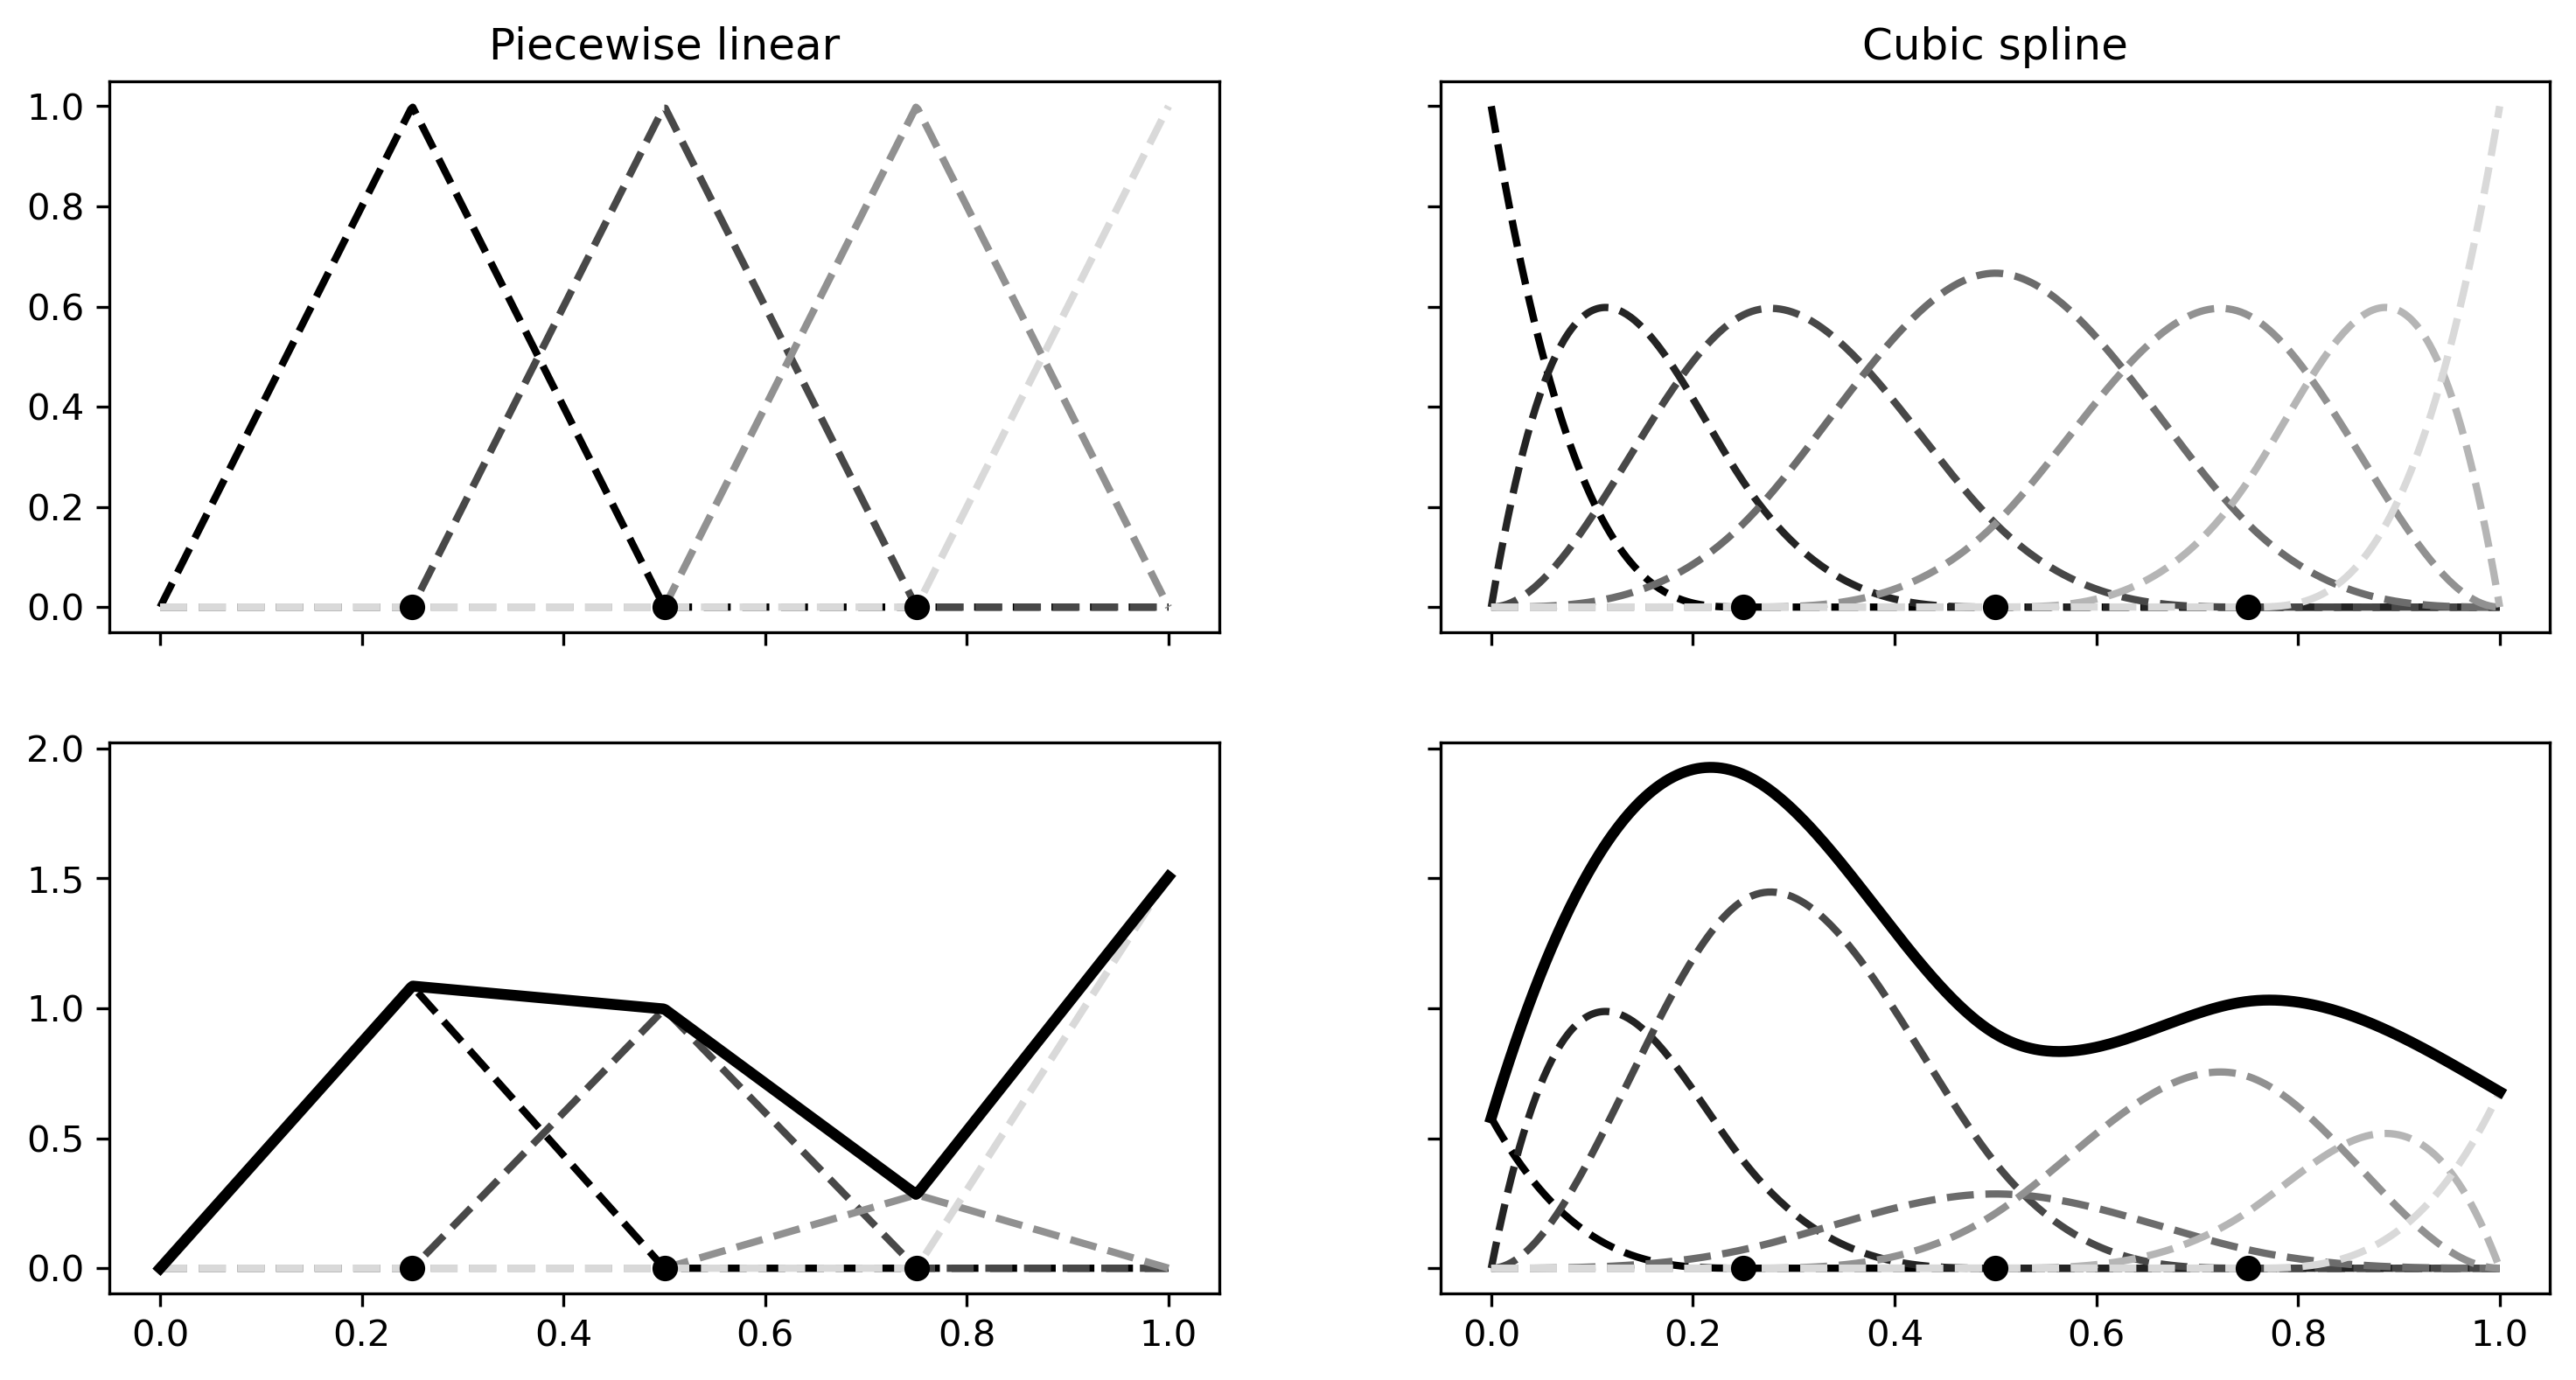

In the above picture, the left column of images is a one degree overlapping piecewise function. The upper left image is with equal weights, and the lower image is different weights. The dark black line is the sum of the curves.

The same is true for the cubic overlapping piecewise functions on the right.

Now that we know what a b spline is, let's try one on the bikes data.

It's here though, that I must mention the biggest draw backs with splines. We need to decide the knot locations, and there isn't a good heurstic for where they should go. Our textbook chose to evenly distribute them, but that might not always work.

And, we still need to choose the degree of our polynomials. Again, we'll go witht the textbooks recommendation of degree 3.

In [11]:
num_knots = 6
knots = np.linspace(0, 23, num_knots+2)[1:-1]
model_spline = bmb.Model("rented ~ bs(hour, degree=3, knots=knots)", bikes, family="negativebinomial")
idata_spline = model_spline.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, degree=3, knots=knots)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: hour


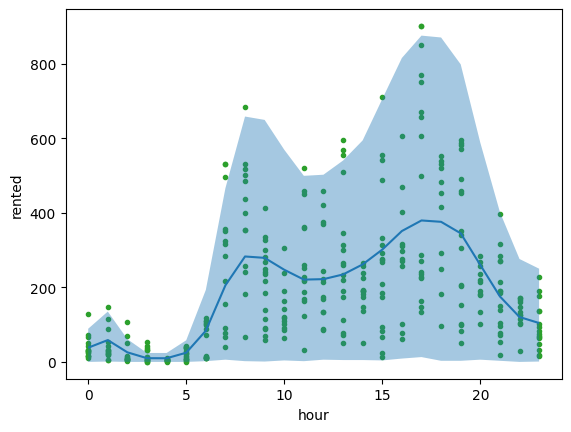

In [12]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "hour", pps= True)
plt.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)

**Task5**:

Describe the fit of model_spline.

The fit does a good job of representing the whole range of the data while drawing the line through where the most data is.

Let's see if the b spline with the same knots and degree will work for the temp versus rented situation.

In [13]:
num_knots = 6
knots = np.linspace(0, 23, num_knots+2)[1:-1]
model_spline_t = bmb.Model("rented ~ bs(temperature, degree=3, knots=knots)", bikes, family="negativebinomial")
idata_spline_t = model_spline_t.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(temperature, degree=3, knots=knots)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temperature


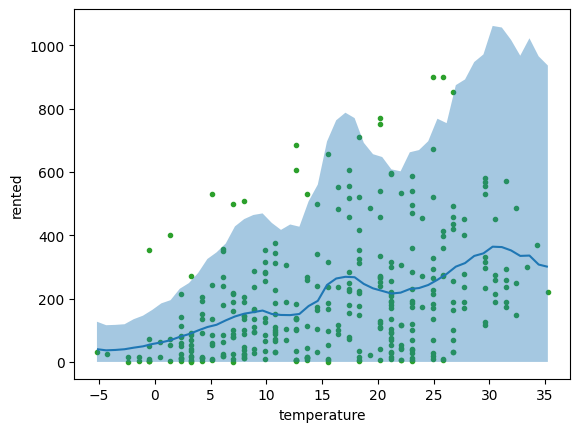

In [14]:
bmb.interpret.plot_predictions(model_spline_t, idata_spline_t, "temperature", pps= True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

**Task6**:

Describe the fit of model_spline_t.

The model seems to be overfitting. It seems to match the data well.

We've now seen how splines can be used to get a precisely fitted curve to our data, with less risk of overfitting that using pure polynomial regression.

Splines achieve this by applying a fixed number of polyminals at set input values, and then applying weights to those polynomials. I'll emphasize this: splines are good at choosing the weights of a set number of polynomials regressions (knots) in a set location.

**Task7**:

How could we determine the location of the knots?

Splines at higher densities of input values could be weighted more.

### A Brief aside on (single layer) Neural Networks (NN)

No, we're not going to make a NN in this unit.

I do want to use splines as a way to explain what a NN is though, because I'll then use that to explain what a Gaussian Process (GP) is. For the rest of the notes, know that I'm refering only to single layer NNs.

First, the relationship between between single layer NNs and splines. In short, a NN is a spline with two key differences:
- MLPs aritecture allows them to choose the location of the knots (the location of the regressions).
- the "knots" in NNs (called nodes by NN people) do not use polynomials, per se. Instead, they use their (activiation) functions to keep track of their relationships to the other knots/nodes.

I'll dicuss that last point more. As the number of knots/nodes grows larger, each knot/node has less data to fit a line to. That means the curve a knot needs to fit is not really the curve from the data in it's own piece, but how that limited data relates to all the other pieces of data.

Ok, so NNs are splines that can choose their own knot/node locations, and have so many knots that they focus on keeping track of all those knots and their relationships.

Now for an interesting fact: in most cases, increasing the number of nodes/knots results in a NN that makes better predictions. This is surprising, because if we follow that trend, it means that each node/knot will come to represent a single data point. So what's going on?

## Gaussian Processes (GPs)

I'll answer a different question first: if NNs are splines that choose their own knot locations, then how do I automatically choose the number of knots?

In other words, how can we use our data to choose its own knot locations? The answer: all our data points are our knot locations!

You know your brain hasn't melted yet if that last point seems wild (if your brain is melting: don't give up! Brain melt is part of the learning process).

To justify using each data point as a knot, consider how NNS treat their nodes/knots: they don't worry as much about fitting a curve to their local data, but instead focus on the relationship between nodes/knots.
In other words, if we set each data point as a knot and focus on the relationship to other knots, then we'll be finding the relationships of the data to itself.

This powerful idea is know as a Gaussian Process (GP). Well, technically applying a knot to all the infinite possible data points and then applying a relationship between the those infinite knots is a GP. But we can avoid the inconvenient infinities by using Bayesian statistics and MCMC to get samples from a real GP with only the available data.

Let's talk about how GPs relate thier data points/knots together. There are two: The main one is kernal/covariance matrix combo, and the secondary one is how we choose to format our data.

Before I talk about those two, I want to return to NNs. Remember when I said NNs don't really care about fitting the points that correspond to a node? That's not wholly true. The way we define a "piece" or define which points are near each other, is how we "fit" a curve within a node. The two popular ways to define closeness in a NN are convolutions and transformers.

This is what I mean by "formatting" the data; we are determining a way to define how "close" points are. NNs usually rely on convolutions and transformers to define closeness, although lots of methods work.

GPs can use any measure of closeness, so long as the data formatting matches well to a kernal. The kernal is how the GP keeps tracks relationships between points--its the "network" part of a GP.

### Why do we care about GPs?

If GPs are basically NNs that can choose the number of nodes, then why aren't GPs more popular than NNs?

GPs are slow, and choosing a kernal for a given data set is hard. In other words, they are too flexible for their own good. Which makes sense, since a true Gaussian process imagines a relationship between all the infinite possible data points.

GPs still have their uses: they are state of the art for many spatial/temporal prediction problems, since "distance" is more intuitive to determine and interpret in thsoe settings. And in scientific research, their slowness isn't usually an issue, and the precise control of the modeling process that GPs provide is good scientific practice.

The point of all this hasn't been for us to make a useful GP though; its been to show you that, although there is no One True Model structure, GPs come pretty close. Moreover, almost all the (current) best predictive tools are speedier approximations of GPs*.

*Excepting clustering (see [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)) and Deep Neural Networks (DNNs), but that's an [emerging area of reasearch](https://arxiv.org/pdf/2106.06529).



### Hibert Space Gaussian Processes (HSGPs)

Let's leave theory aside now, and implement an approximation of a GP.

GLMs and splines are (bad) approximations of GPs, but it's possible to do better, and still have a model that isn't prohibtively slow.

We will use a Hilbert Space Gaussian Process (HSGP). There's a cost to approximating:
- we will be restricted to around two kernals (ways of specifying "distance"), the exponential quadratic and Matern kernals
- we'll be restricted to data with 1 predictor. Apparently up to 3 predictors can work, but I don't even know how I'd do that.
- we lose the flexibility that truer GP approximations have. you'll learn more about that in the exercises.

HSGP have build in functions for both bami and pymc. Let's start by building one in pymc, and generate a posterior mean plot. We'll then make the same model in bambi, but make a posterior predictive plot.

In [ ]:
!pip install preliz

In [15]:
import preliz as pz
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [16]:
bikes = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv')

#convert from pandas to numpy array
rented = bikes["rented"].values
hour = bikes["hour"].values[:,None]

The following function is copied directly from our textbook, BAP3. Per that textbook: the below function finds a weakly informative prior for the smoothness parameter, ℓ (rponounced 'ell') of our GP.

ℓ controls how wiggly the line our GP creates will be, and we need a reasonable prior for ℓ.

We need a good weakly informative prior for ℓ, because if ℓ is too much smaller than the smallest difference between our predictor values, then our GP will play 'connect the dots' and draw straight lines from one data point to the next. If ℓ is larger than the largest difference between data points (the range), then our GP won't be able to tell our data points are different.

Study the function below to understand how we ensure a weakly informative prior.
Or don't; I won't require you to make a GP on your own.

In [17]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

The actual model is below. Note that parameters m and c are unique to HSGPs

In [18]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(hour))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=hour)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=rented)

    idata_hsgp = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, f_hsgp_coeffs, α]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


**Task8**:

Are GPs used as priors, or likelihoods? What about splines? NNs? Are those priors, or likelihoods?

**Answer8**:

GPs are used as priors (since they choose nodes), and thus NNs and splines are as well (I think)

Let's plot our model's mean, and some of the samples used to calculate the mean.

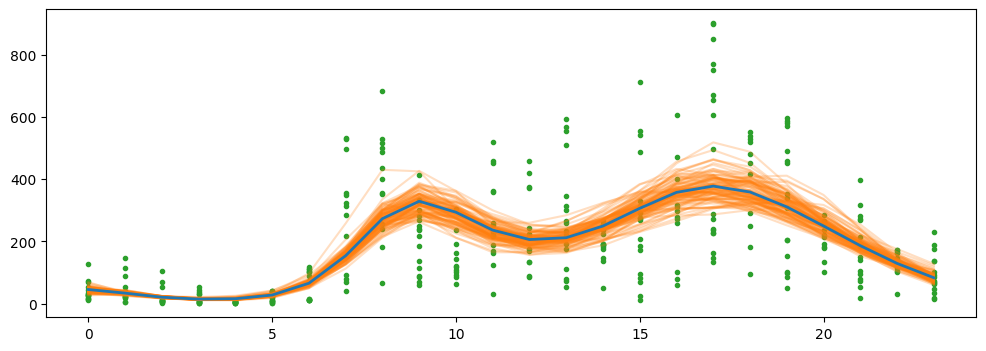

In [19]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(bikes["hour"].values, bikes["rented"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(bikes["hour"].values)
#plot samples of the posterior
ax.plot(bikes["hour"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(bikes["hour"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

Looks pretty, doesn't it?

#### HSGP with Bambi

HSGPs are implemented in bambi. This makes plotting a little more comvenient, expecially if we want a posterior predictive distribution. And we nearly always want a plot of the posterior predictive distribution.

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi

In [20]:
import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [21]:
bikes = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv')

#convert from pandas to numpy array
rented = bikes["rented"].values
hour = bikes["hour"].values[:,None]

In [22]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(hour))
}

priors = {
    "hsgp(hour, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("rented ~ 0 + hsgp(hour, m=10, c=1.5)", bikes, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, hsgp(hour, m=10, c=1.5)_sigma, hsgp(hour, m=10, c=1.5)_ell, hsgp(hour, m=10, c=1.5)_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: hour


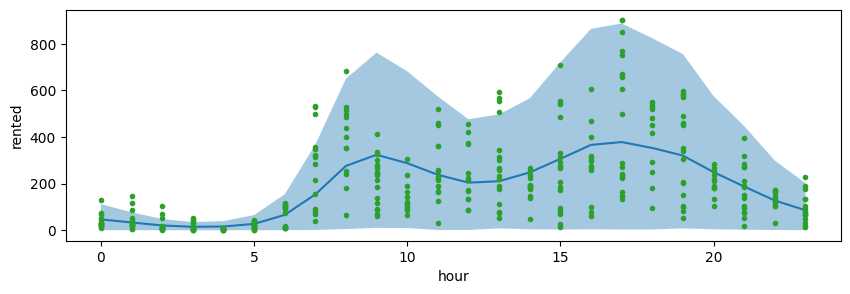

In [23]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["hour"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(bikes["hour"].values, bikes["rented"].values, "C2.")

## Summary

While we only learned three new techniques this unit--polynomial modeling, b splines, and HSGPs--the real work was learning how all of those, plus GLMs, fit together.

Here's the story: Every model we've made from Linear Modeling until now has been a (kinda bad) approximation of a Gaussian Process. Its hard to beat GPs if want to use one or more variables to predict another. That makes sense, because a true GP uses the relationship between all possible data to each other as the prior for its predictions.

The tradeoff though, is that we must actually implement an infinite GP on our very finite computers, and approximations/implementations of GPs have one or more of these problems:
- truer GP implementations can take a LONG time to run
- truer GP implementations can require extensive data preprocessing--as in, more than the usual data wrangling.
- speedy approximations of GPs like GLMs, splines, and even HSGPs, gain that speed by sacrificing the flexibility and power of a truer GP.
- speedy-ish approximations of GPs that don't sacrifcie power or felxibility exist--they're known as NNs--but they gain speed by sacrificing interpretibility.

In the next unit, we'll learn about an approximation of a GP that is a sort of goldilocks of all these tradeoffs: it is only a little less powererful than a moderately sized NN, has the speed of a GLM, and is only a little less interpretable than a GLM.

But that's next unit. For now, go to the exercises, and try your best to understand GPs.

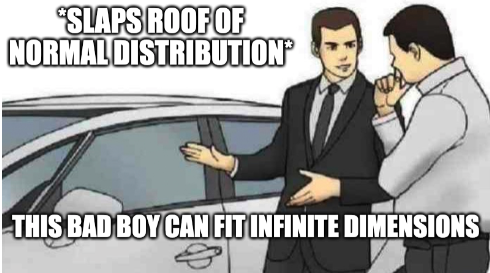

meme created by [Richard McElreath](https://github.com/rmcelreath/stat_rethinking_2024/blob/main/memes/car_badboy_fit_infinite_dims.png)